### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [6]:
experiment_name = 'PMG 284 monitoring'

In [7]:
experiment_names = ['Saccharose hydrolysis',
                   'Silane',
                   'PMG 247 monitoring',
                   'PMG 271 monitoring',
                   'PMG 284 monitoring']

In [8]:
if experiment_name == 'PMG 284 monitoring' and not os.path.exists('../data/PMG_284/serie_1_5.csv'):
    mixture_time_data = pd.read_csv('../data/PMG_284/seria1.csv', sep='\t').iloc[:,:-1]
    mixture_time_data.columns = ['ppm'] + ['seria1_t'+str(i) for i in range(1,1001)]

    for series_nr in range(2,6):
        mixture_time_data_new = pd.read_csv('../data/PMG_284/seria'+str(series_nr)+'.csv', sep='\t').iloc[:,:-1]
        mixture_time_data_new.columns = ['ppm'] + ['seria'+str(series_nr)+'_t'+str(i) for i in range(1,1001)]

        assert np.all(mixture_time_data['ppm'] == mixture_time_data_new['ppm'])
        assert mixture_time_data.shape[0] == mixture_time_data_new.shape[0]

        mixture_time_data = pd.concat([mixture_time_data, mixture_time_data_new.iloc[:,1:]], axis=1)

    assert(np.all(mixture_time_data.iloc[:,1:1001].values == 
                       pd.read_csv('../data/PMG_284/seria1.csv', sep='\t').iloc[:,1:-1].values))

    assert(np.all(mixture_time_data.iloc[:,1001:2001].values == 
                  pd.read_csv('../data/PMG_284/seria2.csv', sep='\t').iloc[:,1:-1].values))

    assert(np.all(mixture_time_data.iloc[:,2001:3001].values == 
           pd.read_csv('../data/PMG_284/seria3.csv', sep='\t').iloc[:,1:-1].values))

    assert(np.all(mixture_time_data.iloc[:,3001:4001].values == 
           pd.read_csv('../data/PMG_284/seria4.csv', sep='\t').iloc[:,1:-1].values))

    assert(np.all(mixture_time_data.iloc[:,4001:5001].values == 
           pd.read_csv('../data/PMG_284/seria5.csv', sep='\t').iloc[:,1:-1].values))

    mixture_time_data.to_csv('../data/PMG_284/serie_1_5.csv', index=False)

In [5]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_1000/all.csv',
                'Silane': '../data/silan/pmg166_3rdseries_full.csv',
                'PMG 247 monitoring': '../data/PMG_247/preprocessed_PMG247_monitoring.csv',
                'PMG 271 monitoring': '../data/PMG_271/PMG271_monitoring_druga_seria.csv',
                'PMG 284 monitoring': '../data/PMG_284/serie_1_5.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_1000/sucrose.csv', 
                                            '../data/saccharose_1000/glucose.csv',
                                            '../data/saccharose_1000/fructose.csv'],
                'Silane': [],
                'PMG 247 monitoring': ['../data/PMG_247/preprocessed_substrate0.csv',
                                      '../data/PMG_247/preprocessed_substrate1.csv'],
                'PMG 271 monitoring': ['../data/PMG_271/preprocessed_substrate0.csv',
                                      '../data/PMG_271/preprocessed_substrate1.csv']
                'PMG 284 monitoring': []}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': ',',
                'PMG 271 monitoring': '\t',
                'PMG 284 monitoring': ','
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': '\t',
                'PMG 271 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_1000/comparing_with_first/known_substrats/',
                'Silane': '../results/silan/comparing_with_first/known_substrats/',
                'PMG 247 monitoring': '../results/PMG_247/comparing_with_first/known_substrats/',
                'PMG 271 monitoring': '../results/PMG_271/comparing_with_first/known_substrats/',
                'PMG 284 monitoring': '../results/PMG_284/comparing_with_first/known_substrats/'}

#### Mixture in time

In [6]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    mixture_time_data = mixture_time_data.iloc[:,:-1]
elif experiment_name == 'PMG 271 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_20th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::20]
    mixture_time_data = pd.concat((ppm, every_20th), axis=1)
elif experiment_name == 'PMG 284 monitoring':


In [7]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [8]:
mixture_time_data.columns = names

In [9]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

#### Reagents

In [10]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [11]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


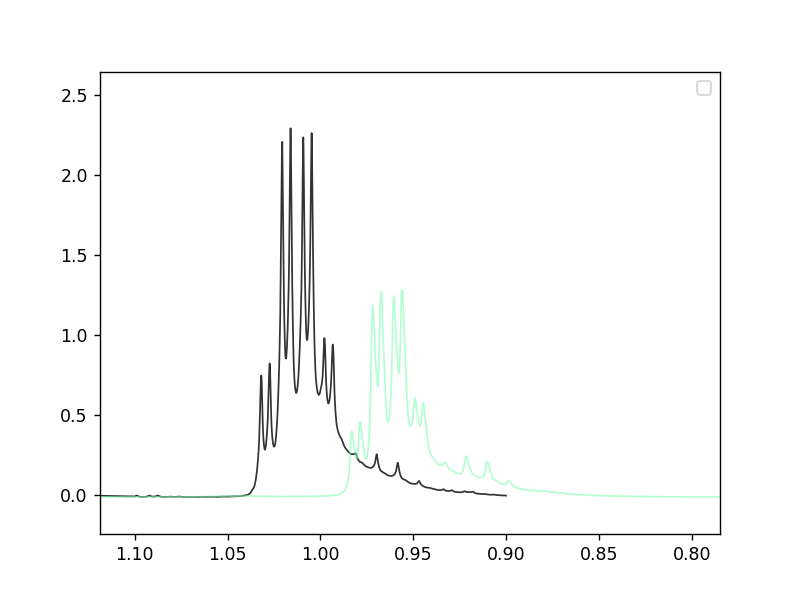

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [17]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 50)], profile=True)

### Estimation

In [13]:
kappa = 1
kappa_th = 0.25

In [14]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []

sp1 = load_spectrum(mixture_time_data, 1)
sp1.trim_negative_intensities()
sp1.normalize()

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.6658396141070012, 0.3341603858930006]


Proportion_of_noise_in_components:

0.002144031065000004


This is timepoint 2.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.
Proportions:

[0.6619235272629993, 0.33807647273699964]


Proportion_of_noise_in_components:

0.0015424752409999986


This is timepoint 3.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 c

Proportions:

[0.660920352745996, 0.339079647253998]


Proportion_of_noise_in_components:

0.002804272633999983


This is timepoint 15.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.
Proportions:

[0.6608269333100013, 0.3391730666900007]


Proportion_of_noise_in_components:

0.0028517104350000056


This is timepoint 16.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 ca

Proportions:

[0.6604008241480015, 0.3395991758520008]


Proportion_of_noise_in_components:

0.0038482477750000086


This is timepoint 28.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.
Proportions:

[0.6602439069199983, 0.33975609307999916]


Proportion_of_noise_in_components:

0.00393116044099999


This is timepoint 29.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 

Proportions:

[0.6604767148640003, 0.33952328513600016]


Proportion_of_noise_in_components:

0.004799761474000002


This is timepoint 41.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized.
Normalizing component's spectrum 0.
Component's spectrum 1 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 1 is not normalized.
Normalizing component's spectrum 1.
Proportions:

[0.6602981642419997, 0.33970183575799984]


Proportion_of_noise_in_components:

0.004812080930999997


This is timepoint 42.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0

In [15]:
len(proportions_in_times)

50

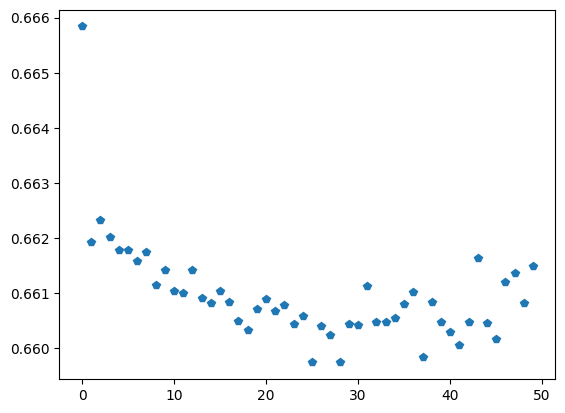

In [16]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')

In [17]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [18]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [19]:
# with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
#     pickle.dump(noise, f)

### Linear regression

In [21]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [22]:
t = np.array(range(1, y.shape[0]+1))
t_and_ones = np.vstack([t, np.ones(len(t))]).T

In [23]:
reagent_number = 1

In [24]:
slope, intercept = np.linalg.lstsq(t_and_ones, y)[0][:,reagent_number]

/tmp/ipykernel_11802/1931212556.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0][:,reagent_number]


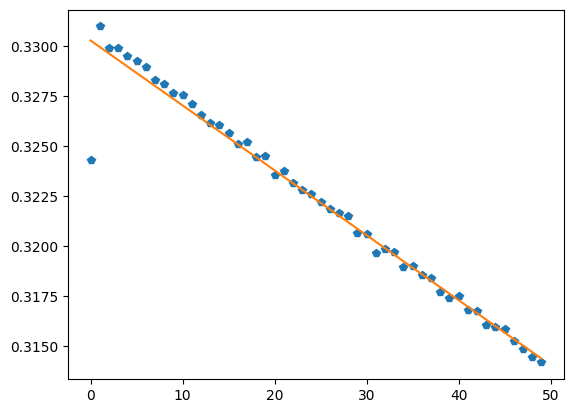

In [25]:
plt.plot(range(len(y)), [prop[reagent_number] for prop in y], 'p')
plt.plot(slope*t+intercept)